In [1]:
import os

if not os.path.exists('dataset1'):
  !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
  !unzip dataset1.zip
  !rm dataset1.zip
  !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%env TF_FORCE_GPU_ALLOW_GROWTH=true

Archive:  dataset1.zip
   creating: dataset1/
   creating: dataset1/annotations_prepped_test/
 extracting: dataset1/annotations_prepped_test/0016E5_08085.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08039.png  
 extracting: dataset1/annotations_prepped_test/0016E5_07995.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08067.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08073.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08123.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08159.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08157.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08047.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08075.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08121.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08053.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08119.png  
  inflating: dataset1/annotations_prepped_test/0

In [2]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [3]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self):
        return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [4]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, collate_fn=val_ds.collate_fn)

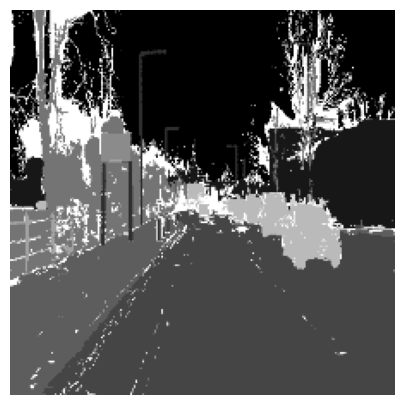

In [5]:
show(trn_ds[10][1])

In [6]:
def conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

def up_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
      nn.ReLU(inplace=True)
  )

In [7]:
from torchvision.models import vgg16_bn

class UNet(nn.Module):
  def __init__(self, pretrained=True, out_channels=12):
    super().__init__()
    self.encoder = vgg16_bn(pretrained=pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512, 1024)

    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512 + 512, 512)
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256 + 512, 256)
    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128 + 256, 128)
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)
    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)

    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)

    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)

    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)

    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)

    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)

    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)

    x = self.conv11(x)

    return x

In [8]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [9]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [10]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


In [11]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 1.236  val_acc: 0.818  val_loss: 0.846  trn_acc: 0.725  (31.23s - 593.42s remaining)
EPOCH: 2.000  trn_loss: 0.707  val_acc: 0.841  val_loss: 0.654  trn_acc: 0.822  (49.93s - 449.37s remaining)
EPOCH: 3.000  trn_loss: 0.573  val_acc: 0.858  val_loss: 0.552  trn_acc: 0.848  (70.27s - 398.21s remaining)
EPOCH: 4.000  trn_loss: 0.509  val_acc: 0.834  val_loss: 0.612  trn_acc: 0.861  (90.48s - 361.93s remaining)
EPOCH: 5.000  trn_loss: 0.480  val_acc: 0.855  val_loss: 0.525  trn_acc: 0.867  (108.39s - 325.18s remaining)
EPOCH: 6.000  trn_loss: 0.439  val_acc: 0.872  val_loss: 0.477  trn_acc: 0.877  (127.68s - 297.92s remaining)
EPOCH: 7.000  trn_loss: 0.423  val_acc: 0.811  val_loss: 0.586  trn_acc: 0.881  (146.56s - 272.18s remaining)
EPOCH: 8.000  trn_loss: 0.400  val_acc: 0.884  val_loss: 0.412  trn_acc: 0.886  (165.89s - 248.84s remaining)
EPOCH: 9.000  trn_loss: 0.361  val_acc: 0.849  val_loss: 0.515  trn_acc: 0.899  (183.68s - 224.50s remaining)
EPOCH: 10.000 

100%|██████████| 121/121 [00:00<00:00, 2423.90it/s]


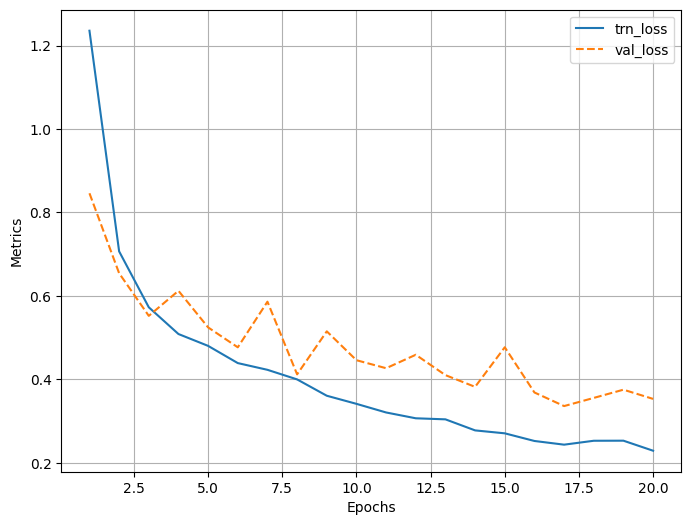

In [12]:
log.plot_epochs(['trn_loss','val_loss'])

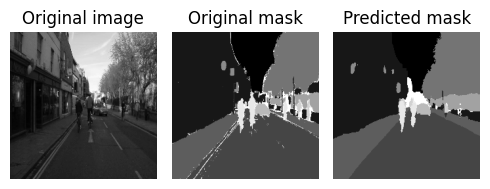

In [13]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

---